In [53]:
import xmltodict, json, feedparser
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time, re
import pandas as pd
from collections import defaultdict
import json
from datetime import datetime
from datetime import date
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from pprint import pprint
import dataframe_image as dfi
import os, sys
from PIL import Image
import cv2
from io import BytesIO
from zipfile import ZipFile
import xml.etree.ElementTree as ET
from ast import literal_eval
import requests
from dateutil.relativedelta import relativedelta
from urllib import parse
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
import numpy as np

import ssl
context = ssl._create_unverified_context()

crtfc_key = '0a8c798b97ddd067012cb38f15aa6252a82d9f13'
url_corpcode = 'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={}'.format(crtfc_key)

with urlopen(url_corpcode, context=context) as zip_response:
    with ZipFile(BytesIO(zip_response.read())) as zfile:
        zfile.extractall()

tree = ET.parse('corpcode.xml')
root = tree.getroot()

def find_stock_code(find_name):
    for company in root.iter('list'):                                                                          
        if company.findtext('corp_name') == find_name:
            if company.findtext('stock_code').isspace(): # None
                continue
            else:
                return company.findtext('stock_code')

In [22]:
def get_sise(code, start_time, end_time, time_from='day') :
        get_param = {
            'symbol':code,
            'requestType':1,
            'startTime':start_time,
            'endTime':end_time,
            'timeframe':time_from
        }
        get_param = parse.urlencode(get_param)
        url="https://api.finance.naver.com/siseJson.naver?%s"%(get_param)
        response = requests.get(url)
        return literal_eval(response.text.strip())

end = datetime.today().strftime('%Y%m%d')
start = (date.today() + relativedelta(months=-36)).strftime('%Y%m%d')

In [91]:
# 공급계약

title = '단일판매ㆍ공급계약체결'

if ('단일판매ㆍ공급계약체결' in title):  # and not('정정' in title):

  companyName = '제룡전기'  # disclosure['author']
  stockCode = find_stock_code(companyName)
  sise_list = get_sise(stockCode, start, end, 'day')
  dfSise = pd.DataFrame(sise_list[1:], columns=sise_list[0])
  dfSise.index = dfSise['날짜']
  dfSise.index.name = 'Date'
  dfSise.drop('날짜', axis=1, inplace=True)

  driver = webdriver.Chrome()
  driver.get('https://dart.fss.or.kr/dsab007/main.do?option=corp')
  driver.maximize_window()
  time.sleep(3)

  stockCodeBox = driver.find_element('id', 'textCrpNm')
  stockCodeBox.send_keys(stockCode)
  driver.find_element('id', 'date5').click()  # 3년 클릭
  driver.find_element('id', 'btnPlus').click()  # 상세조건열기 클릭
  # driver.find_element(By.PARTIAL_LINK_TEXT, '상세조건열기').click()  # 상세조건열기 클릭
  reportNameBox = driver.find_element('id', 'reportName2')
  reportNameBox.send_keys('단일판매ㆍ공급계약체결')

  # -------- 드롭다운 메뉴 100개로 선택 -------------------
  dropdown = Select(driver.find_element('id', 'maxResultsCb'))
  dropdown.select_by_value('100')

  # -------- div style:block 처리 -------------------
  driver.find_element(By.CSS_SELECTOR, "a[class='btnSearch']").click()  # 검색 클릭
  # time.sleep(1)

  # a = driver.find_element(By.CSS_SELECTOR, "div[class='searchPop wrapM']")
  # print(a.get_attribute('innerHTML'))
  # a.click()

  checkBox = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'allCheck')))
  checkBox.click()  # 체크박스(all) 클릭
  driver.find_element('xpath', '/html/body/div[15]/div[2]/div[2]/div[2]/a[1]').click()  # 확인 클릭

  # -------- 마무리 검색 클릭 -------------------
  driver.find_element('xpath', '/html/body/div[4]/div[2]/div[1]/div[2]/div[2]/form[2]/div[2]/div[2]/a[1]').click()  # 검색 다시 클릭
  # driver.find_element(By.CSS_SELECTOR, "a[class='btnSearch']").click()  # 작동이 안 됨...이상
  time.sleep(1)  # 검색 데이터가 하단에 부착 되는데 필요한 시간


  # table = driver.find_element(By.CSS_SELECTOR, "table[class='tbList']")
  # table = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "table[class='tbList']")))
  # print("------------table---------------", table.get_attribute('innerHTML'))

  tbody = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbody')))
  # a = driver.find_element(By.PARTIAL_LINK_TEXT, '제룡전기')
  tbodyCode = tbody.get_attribute('innerHTML')
  links = re.findall(r'id="r_(.*?)"', tbodyCode)
  # links = re.findall(r'id="r_', tbodyCode)
  print(len(links))
  # tbodyCode = tbody.get_attribute('href')
  # links = [tbody.get_attribute('href') for elem in tbody]
  # print(links)
  # print(tbodyCode)
  # print("---------------a-----------------------", tbody.get_attribute('innerHTML'))
  # driver.find_element_by_xpath("//p[@id='one']/following-sibling::p")

  linkUrls = ['https://dart.fss.or.kr/dsaf001/main.do?rcpNo=' + link for link in links]
  # print(linkUrls)

  i = 0
  dfSupplyRaw = []
  for url in linkUrls:

    # option = Options()
    # option.add_argument('headless')
    # driver = webdriver.Chrome(options=option)
    driver.get(url)
    time.sleep(1)
    html_source = driver.page_source

    rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
    dcmNo = re.findall(r"', '(.*?)'\);", html_source)

    # url이 있어야 read_html을 통해 table 가져올 수 있다
    frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

    # tableSupply = []
    try:
      tableSupply = pd.read_html(frame_url, index_col=0)
      tableSupply = tableSupply[3]
      tableSupply.index = tableSupply[1]
      tableSupply.drop(1, axis=1, inplace=True)
      # print('try')
    except:
      tableSupply = pd.read_html(frame_url, index_col=0)
      tableSupply = tableSupply[0]
      tableSupply.index = tableSupply[1]
      tableSupply.drop(1, axis=1, inplace=True)
      # print('except')

    print(i, url)

    keyword = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo='
    bk, keyword, ak = url.partition(keyword)
    contractDate = ak[0:8]

    for index, row in tableSupply.iterrows():
      if '계약금액' in index:
        # contractAmount = f'{int(row[2]):,}'
        contractAmount = int(int(row[2])/1000000000)
        break
    # for index, row in tableSupply.iterrows():
    #   if '수주' in index:
    #     # contractAmount = f'{int(row[2]):,}'
    #     contractDate = row[2]
    #     break
    for index, row in tableSupply.iterrows():
      if '매출액' in index:
        latestSales = int(int(row[2])/1000000000)
        break
    for index, row in tableSupply.iterrows():
      if '%' in index:
        contractSalesRatio = float(f'{round(float(row[2]), 1):,}')
        break
    for index, row in tableSupply.iterrows():
      if '상대방' in index:
        counterpart = row[2]
        break
    for index, row in tableSupply.iterrows():
      if '지역' in index:
        region = row[2]
        break
    for index, row in tableSupply.iterrows():
      if '시작' in index:
        beginningDay = row[2]
        break
    for index, row in tableSupply.iterrows():
      if '종료' in index:
        endingDay = row[2]
        break
    
    try:
      delta = datetime.strptime(endingDay, '%Y-%m-%d')-datetime.strptime(beginningDay, '%Y-%m-%d')
      supplyPeriod = float(delta.days/365)
    except:
      supplyPeriod = None
    dfSupplyRaw.append([contractDate, contractAmount, latestSales, contractSalesRatio, beginningDay, endingDay, supplyPeriod, counterpart, region])

    i = i + 1
    time.sleep(5)

  print(dfSupplyRaw)
  dfSupply = pd.DataFrame(dfSupplyRaw, columns=['날짜', '계약금액(십억)', '최근매출액(십억)', '매출액대비(%)', '시작일', '종료일', '기간(년)', '계약상대방', '공급지역'])
  dfSupply.index = dfSupply['날짜']
  dfSupply.index.name = 'Date'
  dfSupply.index = pd.to_datetime(dfSupply.index, format = '%Y-%m-%d').strftime('%Y%m%d')
  dfSupply.drop('날짜', axis=1, inplace=True)
  
  dfFinal = dfSise.join(dfSupply, how='left', on='Date').fillna(0)  # 같은 날짜 공급계약 복수 처리 미완성

  print(dfSupply)
  print(dfFinal)



20
0 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20221021900083
1 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20221020900156
2 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220916900248
3 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220915900547
4 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220905900369
5 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220712900138
6 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220704900343
7 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220617900120
8 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220617900118
9 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220616900169
10 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220602900268
11 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220602900172
12 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220526900077
13 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220411900194
14 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220406900264
15 https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220404900181

In [13]:
print(url)
keyword = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo='
bk, keyword, ak = url.partition(keyword)
contractDate = ak[0:8]
contractDate

https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20200115800127


'20200115'

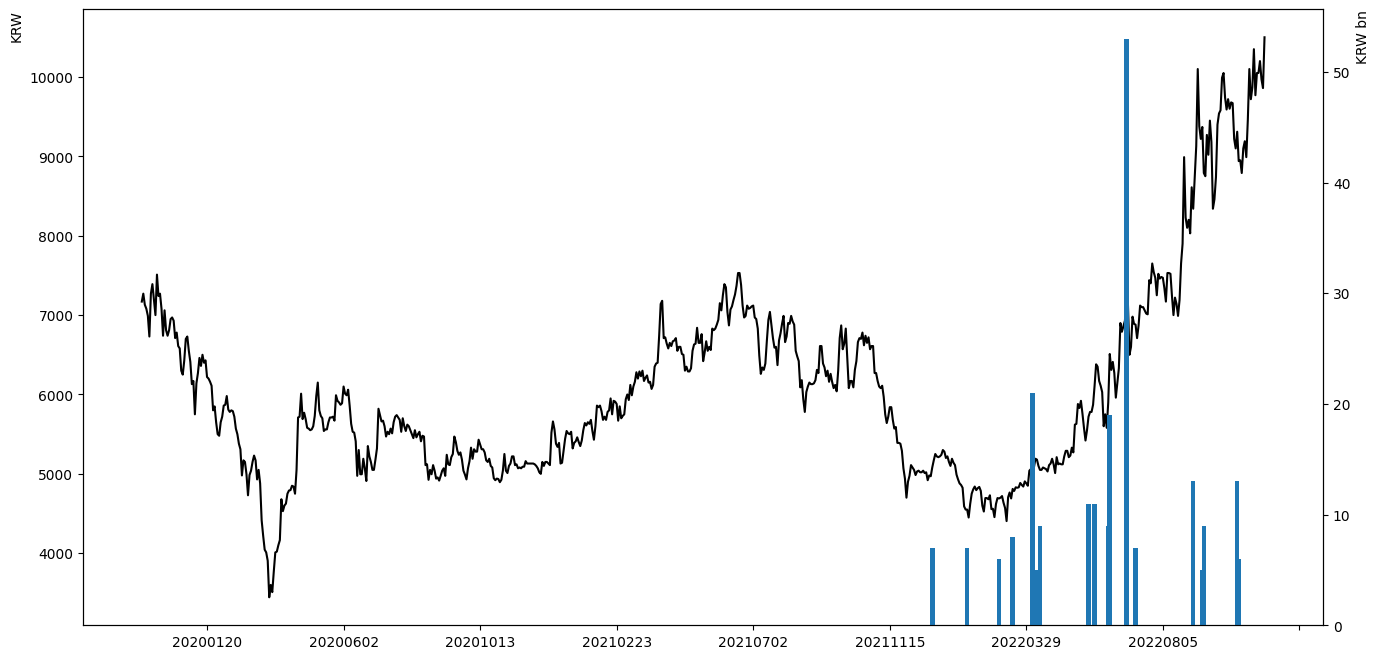

In [97]:
plt.rc('figure', figsize=(16, 8))
# fig, (ax1, ax2) = plt.subplots(2, 1)
fig, axes = plt.subplots(1, 1)
plt.ylabel('KRW', fontsize=10, loc='top')
# plt.title("최근 3년 주가 및 공급계약", fontsize=20)
axes2 = axes.twinx()
axes2.set_ylabel('KRW bn', fontsize=10, loc='top')
priceList = dfFinal['종가'].to_numpy()
contractList = dfFinal['계약금액(십억)'].to_numpy()
ln1 = axes.plot(dfFinal.index, priceList, 'k-', label = 'price(L)')
ln2 = axes2.bar(dfFinal.index, contractList, width=3)
axes.xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.savefig('images/supply table/' + companyName + '_chart_' + datetime.today().strftime("%Y-%m-%d") + '.png')
# lns = [ln1, ln2]
# labs = [l.get_label() for l in lns]
# axes.legend(lns, labs, loc=0, fontsize=12)
# ln2 = ax2.bar(dfFinal.index, contractList, width=3)
# ax2.xaxis.set_major_locator(mdates.DayLocator(interval=90))

In [94]:
dfSupplyTable = pd.DataFrame(dfSupplyRaw, columns=['날짜', '계약금액(십억)', '최근매출액(십억)', '매출액대비(%)', '시작일', '종료일', '기간(년)', '계약상대방', '공급지역'])
dfSupplyTable.index = dfSupplyTable['날짜']
dfSupplyTable.index.name = 'Date'
dfSupplyTable.drop('날짜', axis=1, inplace=True)
dfSupplyTable.index = pd.to_datetime(dfSupplyTable.index, format = '%Y%m%d').strftime('%Y-%m-%d')
dfSupplyTable['계약금액(십억)'] = dfSupplyTable['계약금액(십억)'].apply(lambda x: "{:,}".format(x))
dfSupplyTable['최근매출액(십억)'] = dfSupplyTable['최근매출액(십억)'].apply(lambda x: "{:,}".format(x))

try:
  dfSupplyTable['기간(년)'] = dfSupplyTable['기간(년)'].round(1)
except:
  dfSupplyTable['기간(년)'] = np.nan
  
dfSupplyTable

,계약금액(십억),최근매출액(십억),매출액대비(%),시작일,종료일,기간(년),계약상대방,공급지역
Date,,,,,,,,
2022-10-21,6,48,13.8,2022-10-20,2024-01-31,1.3,LONG ISLAND ELECTRIC UTILITY SERVCO LLC as Age...,미국
2022-10-20,13,48,27.4,2022-10-20,2024-12-31,2.2,Choctaw-Kaul Distribution Company,미국
2022-09-16,9,45,20.6,2021-03-25,2023-06-30,2.3,한국중전기사업협동조합,신청주 변전소
2022-09-15,5,44,12.5,2021-06-30,2024-12-31,3.5,국가철도공단,국가철도공단 호남본부 현장내 지정장소
2022-09-05,13,48,28.0,2022-09-03,2023-12-30,1.3,Public Service Electric and Gas Company,미국
2022-07-12,7,48,16.1,2022-07-08,2024-04-30,1.8,American Electric Power,미국
2022-07-04,53,48,109.2,2022-07-01,2023-12-31,1.5,Public Service Electric and Gas Company,미국
2022-06-17,19,48,40.0,2022-06-17,2023-12-31,1.5,Public Service Electric and Gas Company,미국
2022-06-17,5,44,12.1,2022-01-25,2024-01-09,2.0,한국중전기사업협동조합,증산 변전소


In [98]:
dfi.export(dfSupplyTable, 'images/supply table/' + companyName + '_table_' + datetime.today().strftime("%Y-%m-%d") + '.png')

In [83]:
today = datetime.today().strftime('%Y-%m-%d')

'2022-11-15'

In [79]:
dfSupplyTable['계약금액(십억)'].apply(lambda x: "{:,}".format(x))

Date
2022-11-04    1,222
2022-10-19      469
2022-10-07      590
2022-10-07      629
2022-10-07      455
2022-09-22      750
2022-09-16      393
2022-08-24    1,826
2022-07-29      685
2022-07-29      723
2022-07-29      580
2022-05-20      541
2022-03-02      506
2022-02-28      772
2022-02-25      472
2022-01-28      535
2022-01-26      367
2022-01-25      453
2021-11-30      876
2021-11-23      612
2021-10-25      660
2021-10-15      604
2021-07-12      508
2021-06-30    1,792
2021-06-24    1,457
2021-06-24    1,718
2021-06-21    1,074
2021-06-18      948
2021-06-14      459
2021-06-04      557
2021-06-01      497
2021-05-17    1,189
2021-04-15      901
2021-02-23    1,643
2021-02-16    2,025
2021-02-15    1,768
2021-02-15      711
2020-12-30      568
2020-12-30    3,715
2020-12-11    1,737
2020-11-18      588
2020-11-18      630
2020-04-24    1,999
2020-01-15      674
Name: 계약금액(십억), dtype: object

In [84]:
dfFinal.to_csv('supply.csv')

In [54]:
a = tableSupply[0]
a

,1,2,3
0,,,
1. 판매ㆍ공급계약 내용,1. 판매ㆍ공급계약 내용,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...
2. 계약내역,조건부 계약여부,미해당,미해당
2. 계약내역,확정 계약금액,13382052000,13382052000
2. 계약내역,조건부 계약금액,-,-
2. 계약내역,계약금액 총액(원),13382052000,13382052000
2. 계약내역,최근 매출액(원),48783124675,48783124675
2. 계약내역,매출액 대비(%),27.4,27.4
3. 계약상대방,3. 계약상대방,Choctaw-Kaul Distribution Company,Choctaw-Kaul Distribution Company
-최근 매출액(원),-최근 매출액(원),-,-


In [58]:
dfFinal.loc['20221020']

시가                    9110
고가                    9610
저가                    9080
종가                    9310
거래량                 652173
외국인소진율                1.75
계약금액          6743943350.0
최근매출액       48,783,124,675
매출액대비(%)              13.8
시작일             2022-10-20
종료일             2024-01-31
Name: 20221020, dtype: object

In [71]:
driver = webdriver.Chrome()
driver.get('https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20221020900156')
time.sleep(1)
html_source = driver.page_source

rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
dcmNo = re.findall(r"', '(.*?)'\);", html_source)

# url이 있어야 read_html을 통해 table 가져올 수 있다
frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

try:
  tableSupply = pd.read_html(frame_url, index_col=0)
  tableSupply = tableSupply[3]
  tableSupply.index = tableSupply[1]
  tableSupply.drop(1, axis=1, inplace=True)
  print('try')
except:
  tableSupply = pd.read_html(frame_url, index_col=0)
  tableSupply = tableSupply[0]
  tableSupply.index = tableSupply[1]
  tableSupply.drop(1, axis=1, inplace=True)
  print('except')

except


In [72]:
tableSupply

,2,3
1,,
1. 판매ㆍ공급계약 내용,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...
조건부 계약여부,미해당,미해당
확정 계약금액,13382052000,13382052000
조건부 계약금액,-,-
계약금액 총액(원),13382052000,13382052000
최근 매출액(원),48783124675,48783124675
매출액 대비(%),27.4,27.4
3. 계약상대방,Choctaw-Kaul Distribution Company,Choctaw-Kaul Distribution Company
-최근 매출액(원),-,-


In [70]:
tableSupply

,2,3
1,,
1. 판매ㆍ공급계약 내용,미국 LONG ISLAND ELECTRIC UTILITY SERVCO LLC 주상변...,미국 LONG ISLAND ELECTRIC UTILITY SERVCO LLC 주상변...
조건부 계약여부,미해당,미해당
확정 계약금액,6743943350,6743943350
조건부 계약금액,-,-
계약금액 총액(원),6743943350,6743943350
최근 매출액(원),48783124675,48783124675
매출액 대비(%),13.8,13.8
3. 계약상대방,LONG ISLAND ELECTRIC UTILITY SERVCO LLC as Age...,LONG ISLAND ELECTRIC UTILITY SERVCO LLC as Age...
-최근 매출액(원),-,-


In [65]:
tableSupply

,2,3
1,,
1. 판매ㆍ공급계약 내용,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...
조건부 계약여부,미해당,미해당
확정 계약금액,13382052000,13382052000
조건부 계약금액,-,-
계약금액 총액(원),13382052000,13382052000
최근 매출액(원),48783124675,48783124675
매출액 대비(%),27.4,27.4
3. 계약상대방,Choctaw-Kaul Distribution Company,Choctaw-Kaul Distribution Company
-최근 매출액(원),-,-


In [41]:
tableSupply[0].index = tableSupply[0][1]
tableSupply[0]

,1,2,3
1,,,
1. 판매ㆍ공급계약 내용,1. 판매ㆍ공급계약 내용,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...,미국 Choctaw-Kaul Distribution Company PAD 변압기 1...
조건부 계약여부,조건부 계약여부,미해당,미해당
확정 계약금액,확정 계약금액,13382052000,13382052000
조건부 계약금액,조건부 계약금액,-,-
계약금액 총액(원),계약금액 총액(원),13382052000,13382052000
최근 매출액(원),최근 매출액(원),48783124675,48783124675
매출액 대비(%),매출액 대비(%),27.4,27.4
3. 계약상대방,3. 계약상대방,Choctaw-Kaul Distribution Company,Choctaw-Kaul Distribution Company
-최근 매출액(원),-최근 매출액(원),-,-


In [6]:
frame_url

'https://dart.fss.or.kr/report/viewer.do?rcpNo=20221011900709&dcmNo=8833189&eleId=0&offset=0&length=0&dtd=HTML'

In [165]:
tableSupply

[                                                                                                    0  \
 1                                                                                                       
 1. 판매ㆍ공급계약 내용                                                                           1. 판매ㆍ공급계약 내용   
 조건부 계약여부                                                                                      2. 계약내역   
 확정 계약금액                                                                                       2. 계약내역   
 조건부 계약금액                                                                                      2. 계약내역   
 계약금액 총액(원)                                                                                    2. 계약내역   
 최근 매출액(원)                                                                                     2. 계약내역   
 매출액 대비(%)                                                                                     2. 계약내역   
 3. 계약상대방                                     

In [19]:
dfSupply

,계약금액,최근매출액,매출액대비(%),시작일,종료일
Date,,,,,
20221020,6743943350,"48,783,124,675",13.8,2022-10-20,2024-01-31


In [156]:
tableSupply

,2,3
1,,
1. 판매ㆍ공급계약 내용,미국 LONG ISLAND ELECTRIC UTILITY SERVCO LLC 주상변...,미국 LONG ISLAND ELECTRIC UTILITY SERVCO LLC 주상변...
조건부 계약여부,미해당,미해당
확정 계약금액,6743943350,6743943350
조건부 계약금액,-,-
계약금액 총액(원),6743943350,6743943350
최근 매출액(원),48783124675,48783124675
매출액 대비(%),13.8,13.8
3. 계약상대방,LONG ISLAND ELECTRIC UTILITY SERVCO LLC as Age...,LONG ISLAND ELECTRIC UTILITY SERVCO LLC as Age...
-최근 매출액(원),-,-


In [117]:
companyName = '피엔티'
stockCode = find_stock_code(companyName)
sise_list = get_sise(stockCode, start, end, 'day')
dfSise = pd.DataFrame(sise_list[1:], columns=sise_list[0])
dfSise.index = dfSise['날짜']
dfSise.index.name = 'Date'
dfSise.drop('날짜', axis=1, inplace=True)

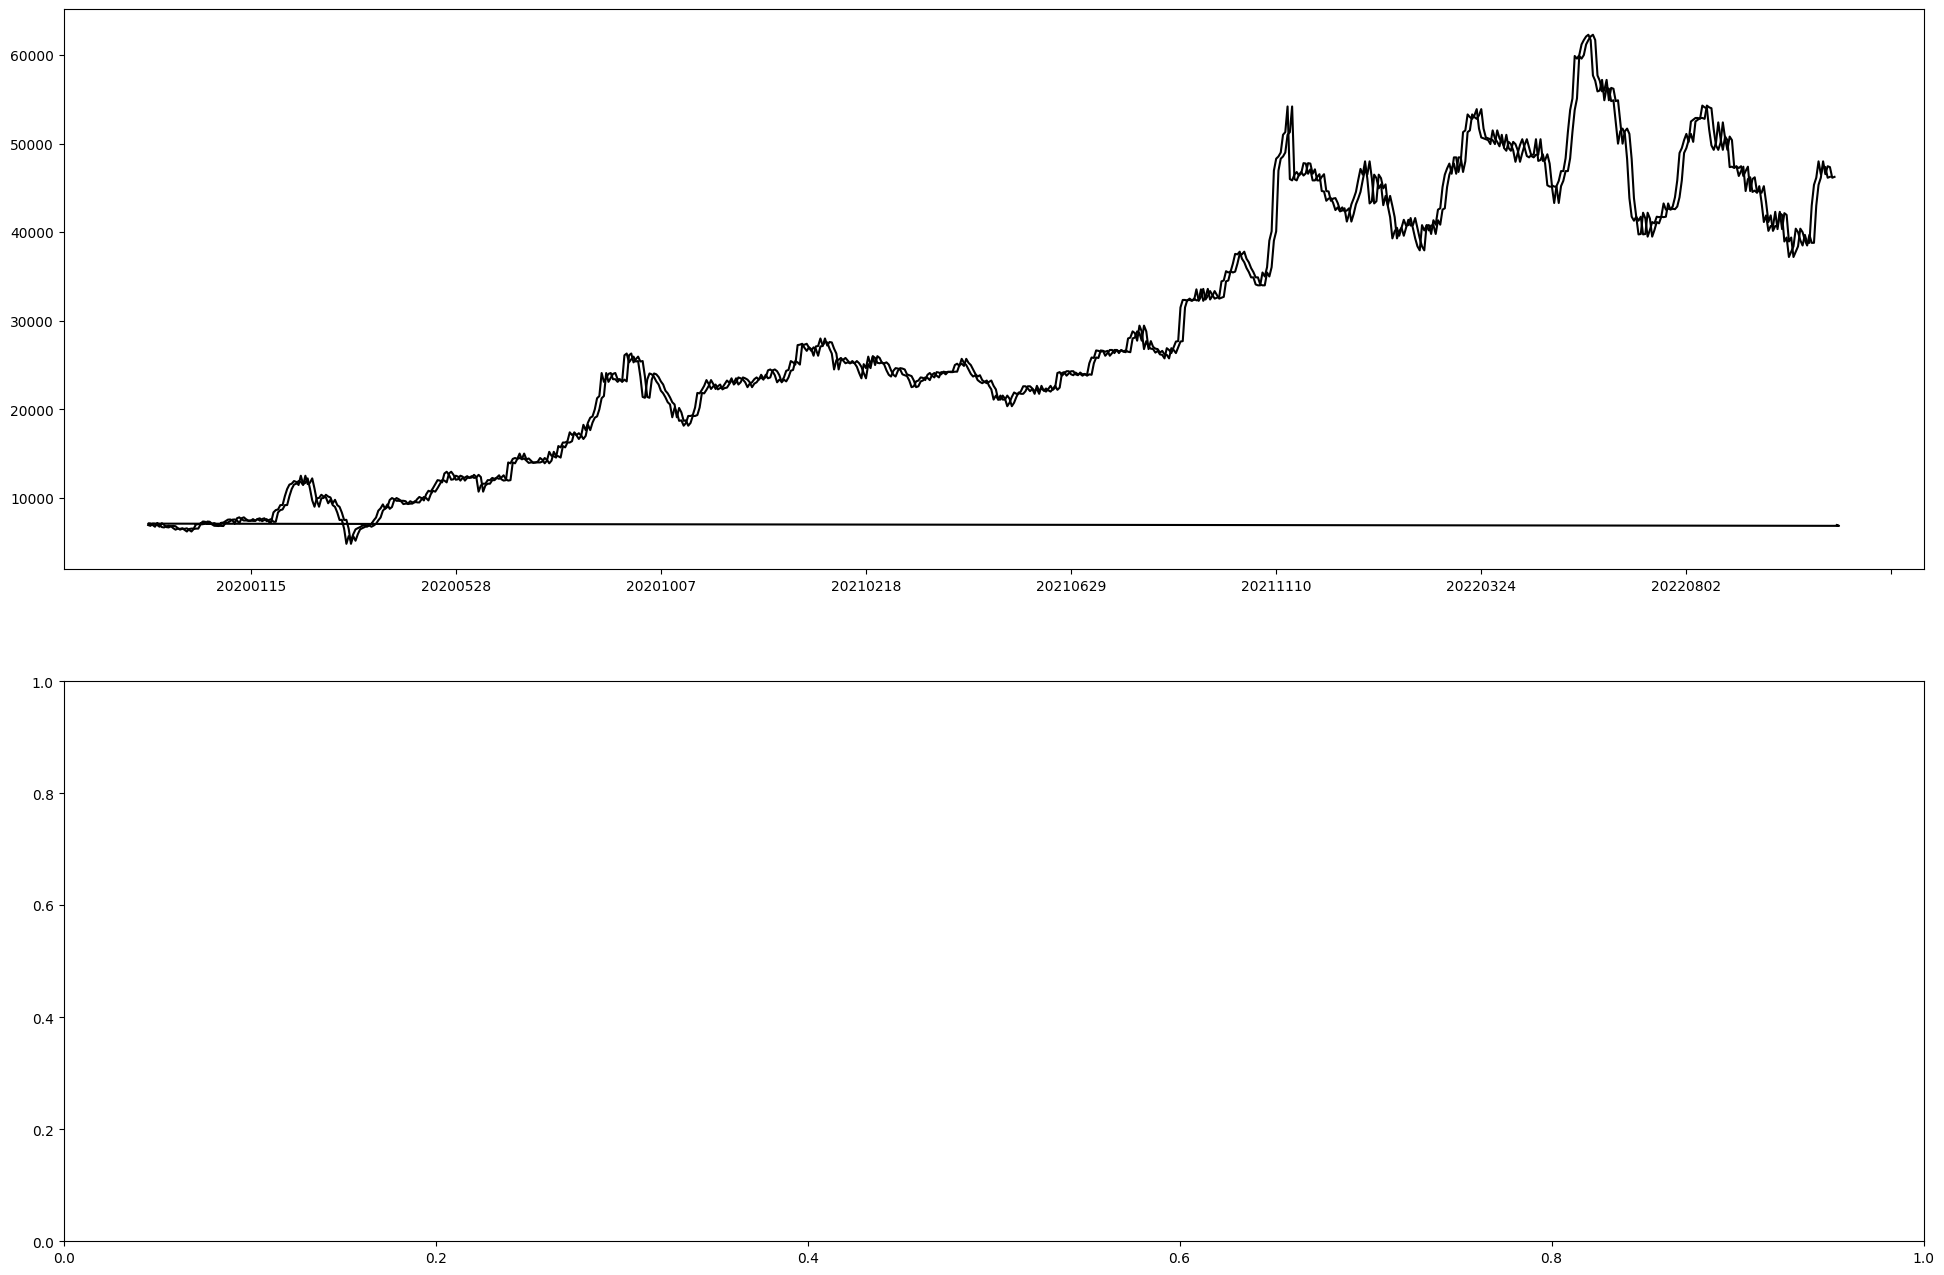

In [129]:
plt.rc('figure', figsize=(24, 16))
fig, (ax1, ax2) = plt.subplots(2, 1)
priceList = dfSise['종가'].to_numpy()
contractList = dfFinal['계약금액'].to_numpy()
ln1 = ax1.plot(dfSise.index, priceList, 'k-', label = 'price(L)')
ln2 = ax1.plot(dfFinal.index, priceList, 'k-', label = 'price(L)')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=90))


In [33]:
priceList

array([ 7120,  6900,  6930,  6840,  7090,  7070,  6930,  6740,  7140,
        6950,  6700,  6660,  6800,  6830,  6800,  6580,  6410,  6520,
        6500,  6560,  6380,  6200,  6480,  6530,  6530,  7000,  7030,
        7080,  7330,  7300,  7080,  7150,  7010,  6850,  6840,  6820,
        7180,  7210,  7380,  7540,  7560,  7450,  7130,  7700,  7800,
        7580,  7440,  7450,  7400,  7400,  7600,  7430,  7610,  7690,
        7370,  7500,  7600,  7300,  7300,  8360,  8620,  8690,  9180,
        9190, 10200, 11000, 11500, 11600, 11900, 11800, 11450, 12500,
       11550, 11700, 12200, 11050,  9720,  9000,  9950,  9990, 10350,
       10150, 10050,  9390,  9780,  9180,  8980,  8340,  7500,  7520,
        6510,  4810,  5680,  5160,  5890,  6440,  6580,  6700,  6860,
        6890,  6740,  6880,  7070,  7460,  7780,  8550,  8820,  9260,
        8760,  8970,  9760,  9980,  9840,  9670,  9670,  9620,  9300,
        9350,  9350,  9620,  9490,  9480,  9840, 10100,  9970,  9710,
       10400, 10800,

In [5]:
find_stock_code('피엔티')

'137400'

In [138]:
# 공급계약

title = '단일판매ㆍ공급계약체결'
link = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20221020900156'
companyName = '제룡전기'
text = title
date = '2019-11-12'

if ('단일판매ㆍ공급계약체결' in title):  # and not('정정' in title):

  option = Options()
  option.add_argument('headless')
  driver = webdriver.Chrome(options=option)
  driver.get(link)
  # time.sleep(2)
  html_source = driver.page_source

  rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
  dcmNo = re.findall(r"', '(.*?)'\);", html_source)

  # url이 있어야 read_html을 통해 table 가져올 수 있다
  frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

  table_ifrm = pd.read_html(frame_url, index_col=1)

  for index, row in table_ifrm[0].iterrows():
    if '계약금액' in index:
      # contractAmount = f'{int(row[2]):,}'
      contractAmount = int(row[2])
      break
  for index, row in table_ifrm[0].iterrows():
    if '매출액' in index:
      latestSales = f'{int(row[2]):,}'
      break
  for index, row in table_ifrm[0].iterrows():
    if '%' in index:
      contractSalesRatio = f'{round(float(row[2]), 1):,}'
      break
  for index, row in table_ifrm[0].iterrows():
    if '상대방' in index:
      counterPart = row[2]
      break
  for index, row in table_ifrm[0].iterrows():
    if '시작' in index:
      beginningDay = row[2]
      break
  for index, row in table_ifrm[0].iterrows():
    if '종료' in index:
      endingDay = row[2]
      break
  
  beginningDay


In [140]:
dfSupply = pd.DataFrame([[date, contractAmount, latestSales, contractSalesRatio, beginningDay, endingDay]], columns=['날짜', '계약금액', '최근매출액', '매출액대비(%)', '시작일', '종료일'])
dfSupply.index = dfSupply['날짜']
dfSupply.index.name = 'Date'
dfSupply.index = pd.to_datetime(dfSupply.index, format = '%Y-%m-%d').strftime('%Y%m%d')
dfSupply.drop('날짜', axis=1, inplace=True)

# indexOpConsF = pd.to_datetime(indexOpConsF, format = '%Y-%m-%d').strftime('%Y%m%d')
# dfOpConsF.index = indexOpConsF

In [141]:
dfSupply

,계약금액,최근매출액,매출액대비(%),시작일,종료일
Date,,,,,
20191112,13382052000,"48,783,124,675",27.4,2022-10-20,2024-12-31


In [142]:
dfFinal = dfSise.join(dfSupply, how='left', on='Date').fillna(0)

In [143]:
dfFinal

,시가,고가,저가,종가,거래량,외국인소진율,계약금액,최근매출액,매출액대비(%),시작일,종료일
Date,,,,,,,,,,,
20191108,6990,7100,6920,6930,288298,1.26,0.000000e+00,0,0,0,0
20191111,6930,6980,6790,6840,219765,1.37,0.000000e+00,0,0,0,0
20191112,6820,7130,6760,7090,298174,1.35,1.338205e+10,"48,783,124,675",27.4,2022-10-20,2024-12-31
20191113,7060,7360,6970,7070,660356,0.69,0.000000e+00,0,0,0,0
20191114,7050,7160,6810,6930,332082,0.80,0.000000e+00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20221102,48000,48350,45850,46550,362927,8.76,0.000000e+00,0,0,0,0
20221103,45050,47650,45000,47450,284887,8.89,0.000000e+00,0,0,0,0
20221104,47050,48150,46800,47350,268538,8.92,0.000000e+00,0,0,0,0


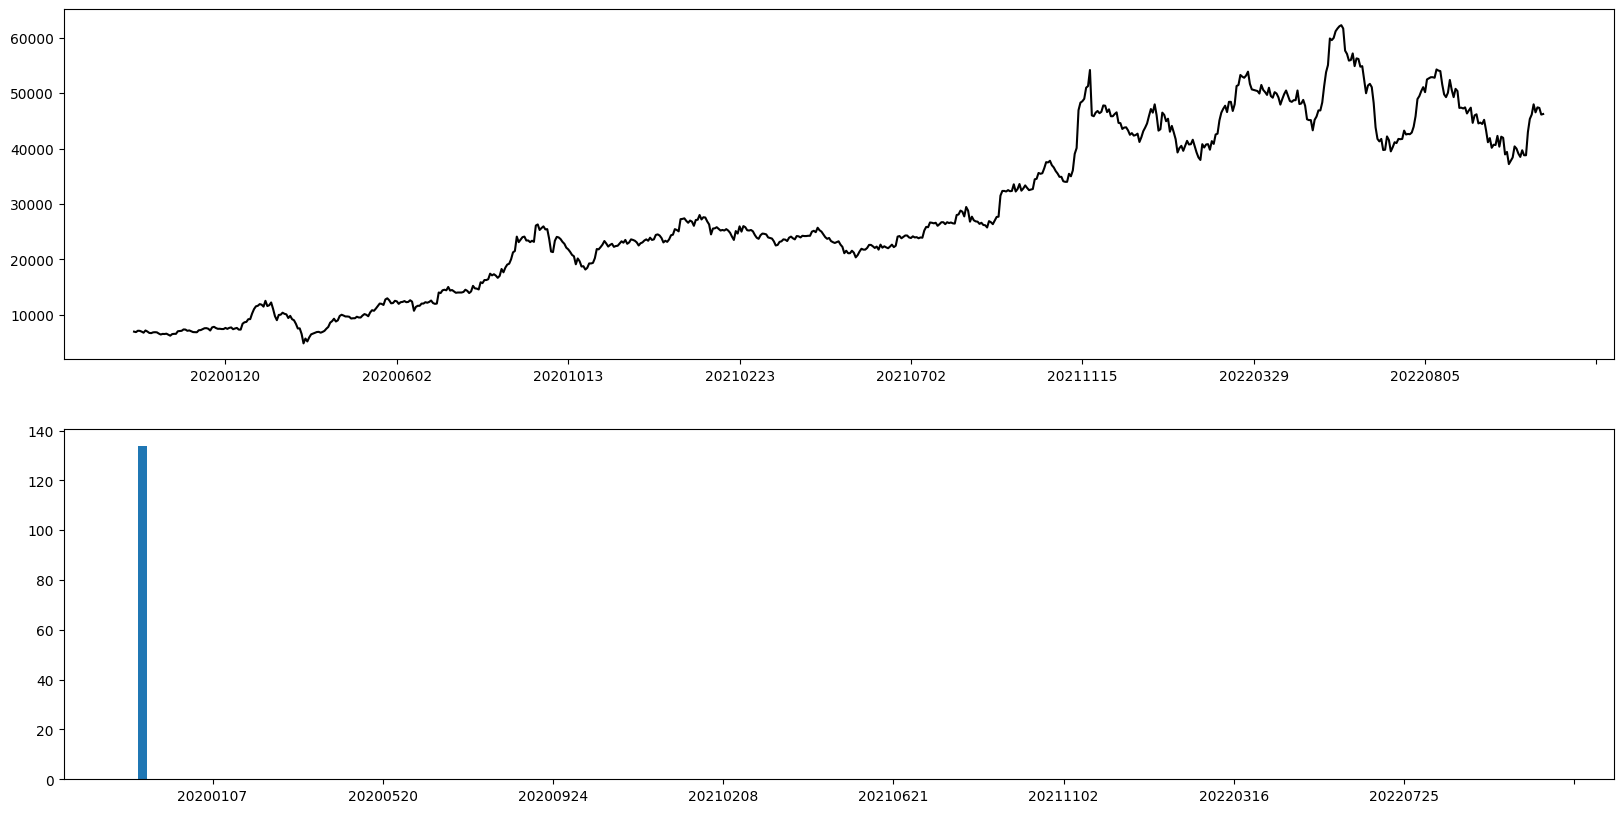

In [144]:
plt.rc('figure', figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(2, 1)
priceList = dfSise['종가'].to_numpy()
contractList = dfFinal['계약금액'].to_numpy()/100000000
ln1 = ax1.plot(dfFinal.index, priceList, 'k-', label = 'price(L)')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=90))
ln2 = ax2.bar(dfFinal.index, contractList, width=5)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=90))

In [128]:
dfSise.index

Index(['20191108', '20191111', '20191112', '20191113', '20191114', '20191115',
       '20191118', '20191119', '20191120', '20191121',
       ...
       '20221026', '20221027', '20221028', '20221031', '20221101', '20221102',
       '20221103', '20221104', '20221107', '20221108'],
      dtype='object', name='Date', length=741)

In [105]:
contractList = dfFinal['계약금액'].to_numpy()
contractList

array([0, '13,382,052,000', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
td = date.fromisoformat(endingDay.replace("'",'')) - date.fromisoformat(beginningDay.replace("'",''))
td

AttributeError: 'str' object has no attribute 'fromisoformat'

In [30]:
table_ifrm[0]

,0,2,3
1,,,
1. 판매ㆍ공급계약 내용,1. 판매ㆍ공급계약 내용,IBC101 CAR-T 세포 제조 위수탁 계약,IBC101 CAR-T 세포 제조 위수탁 계약
조건부 계약여부,2. 계약내역,미해당,미해당
확정 계약금액,2. 계약내역,480000000,480000000
조건부 계약금액,2. 계약내역,-,-
계약금액 총액(원),2. 계약내역,480000000,480000000
최근 매출액(원),2. 계약내역,909090909,909090909
매출액 대비(%),2. 계약내역,52.8,52.8
3. 계약상대방,3. 계약상대방,(주)이노베이션바이오,(주)이노베이션바이오
-최근 매출액(원),-최근 매출액(원),0,0
